In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['font.size'] = 15
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = 16,8

from collections import Counter,defaultdict
from itertools import chain, combinations

import warnings
warnings.filterwarnings('ignore')

import imshow
from wordcloud import WordCloud
from PIL import Image

from itertools import chain

import re
from konlpy.tag import Okt, Mecab
import nltk
from nltk.corpus import stopwords


from collections import Counter
import pickle

import sent2vec
import hnswlib
from gensim.models import Word2Vec
from gensim import corpora
from scipy.sparse import *
from scipy.sparse.linalg import svds

# -------
add_dict = pickle.load(open('/home/ubuntu/workspace/jh/project/data/add_user_dictionary.pickle','rb'))
stopword = pickle.load(open('data/stopword.pickle','rb'))

m = Mecab('/home/ubuntu/workspace/mecab-ko-dic-2.1.1-20180720')

In [2]:
train = pd.read_json('data/train.json')
train['tags__'] = train['tags'].apply(lambda x : " ".join(x))
train['plylst_title__'] = train['plylst_title']
train.head()

,tags,id,plylst_title,songs,like_cnt,updt_date,tags__,plylst_title__
0,[락],61281,여행같은 음악,"[525514, 129701, 383374, 562083, 297861, 13954...",71,2013-12-19 18:36:19.000,락,여행같은 음악
1,"[추억, 회상]",10532,요즘 너 말야,"[432406, 675945, 497066, 120377, 389529, 24427...",1,2014-12-02 16:19:42.000,추억 회상,요즘 너 말야
2,"[까페, 잔잔한]",76951,"편하게, 잔잔하게 들을 수 있는 곡.-","[83116, 276692, 166267, 186301, 354465, 256598...",17,2017-08-28 07:09:34.000,까페 잔잔한,"편하게, 잔잔하게 들을 수 있는 곡.-"
3,"[연말, 눈오는날, 캐럴, 분위기, 따듯한, 크리스마스캐럴, 겨울노래, 크리스마스,...",147456,크리스마스 분위기에 흠뻑 취하고 싶을때,"[394031, 195524, 540149, 287984, 440773, 10033...",33,2019-12-05 15:15:18.000,연말 눈오는날 캐럴 분위기 따듯한 크리스마스캐럴 겨울노래 크리스마스 겨울왕국 크리스마스송,크리스마스 분위기에 흠뻑 취하고 싶을때
4,[댄스],27616,추억의 노래 ㅋ,"[159327, 553610, 5130, 645103, 294435, 100657,...",9,2011-10-25 13:54:56.000,댄스,추억의 노래 ㅋ


# 1. mecab을 통한 자연어 전처리

1. 영어의 경우는 소문자 처리
2. 전처리시 단어의 제한과 통제를 위해 아래 표에 해당하는 품사들만 추출

|품사|---|
|-----|-----|
|NNG|일반 명사|
|NNP|고유 명사|
|VV|동사|
|VA|형용사|
|SL|외국어|
|SN|숫자|
|XR|어근|
|VA+ETM|---|
|VV+EC+VX+ETM|---|

3. 불용어 제거 처리

## 1_1. 자연어 전처리 함수 생성

In [11]:

def konlpy_preprocessing(text, removes_stopwords = False, stop_words = []):
    parts_of_speech = []
    # mecab으로 원하는 품사만 뽑아오기
    for word, tag in m.pos(text.lower()):
        if tag in ['NNP', 'NNG', 'VA', 'VV', 'SL', 'SN', 'XR', 'VA+ETM', 'VV+EC+VX+ETM']:
            parts_of_speech.append(word)
    
#   stopwords에 있는 단어 제거
    if removes_stopwords == True:
        parts_of_speech = [token for token in parts_of_speech if not token in stop_words]    

        stops = set(stopwords.words('english')) # 영어 불용어 불러오기

        parts_of_speech = [w for w in parts_of_speech if not w in stops] 
    
    return " ".join(parts_of_speech)

## 1_2. 태그와 플레이리스트 타이틀 전처리 

- 전처리와 완료된 플레이리스트 타이틀과 태그를 합쳐 new_tags로 생성
- 사용하기 쉽게 json으로 저장

In [ ]:

tag = [konlpy_preprocessing(txt, removes_stopwords=True, stop_words=stopword) for txt in train['tags__']]
title_to_tag = [konlpy_preprocessing(txt,removes_stopwords=True, stop_words=stopword) for txt in train['plylst_title__']]

In [14]:
konlpy_text = pd.DataFrame()
konlpy_text['tags'] = [x.split() for x in tag]
konlpy_text['title'] = [x.split() for x in title_to_tag]
konlpy_text['new_tags'] = konlpy_text['tags'] + konlpy_text['title']
konlpy_text['new_tags'] = [list(set(x)) for x in konlpy_text['new_tags']]
konlpy_text.to_json('data/1108_konlpy_text.json', orient = 'records')
konlpy_text.head()

,tags,title,new_tags
0,[락],"[여행, 음악]","[음악, 락, 여행]"
1,"[추억, 회상]",[],"[추억, 회상]"
2,"[까페, 잔잔]","[편하, 잔잔, 곡]","[편하, 잔잔, 곡, 까페]"
3,"[연말, 눈, 날, 캐럴, 분위기, 따듯, 크리스마스, 캐럴, 겨울, 노래, 크리스...","[크리스마스, 분위기, 취하]","[눈, 분위기, 따듯, 크리스마스, 캐럴, 취하, 노래, 왕국, 겨울, 송, 날, 연말]"
4,[댄스],"[추억, 노래]","[댄스, 추억, 노래]"


# 특정 단어 제거

- 빈도수가 낮아 의미가 없다고 파악되는 단어를 제거
- 제거하는 단어 중에 사용자 사전에 추가한 단어들은 중요한 단어라고 판단하고 제거하기 않음

In [17]:
unnest = np.dstack(
        (np.repeat(konlpy_text.index.values,list(map(len,konlpy_text.new_tags))),
         np.concatenate(konlpy_text.new_tags.values))
             )

unnest_df = pd.DataFrame(unnest[0],columns = ['id','new_tags'])

ddf = pd.DataFrame(unnest_df['new_tags'].value_counts())
ddf.reset_index(inplace=True)
ddf.columns = ['new_tags','cnt']
ddf['len'] = ddf['new_tags'].apply(lambda x:len(x))
ddf['1'] = 1
ddf

,new_tags,cnt,len,1
0,노래,20906,2,1
1,감성,17465,2,1
2,기분전환,16539,4,1
3,듣,16095,1,1
4,음악,14738,2,1
...,...,...,...,...
27636,어금니,1,3,1
27637,스프링스,1,4,1
27638,캔디스,1,3,1
27639,누이,1,2,1


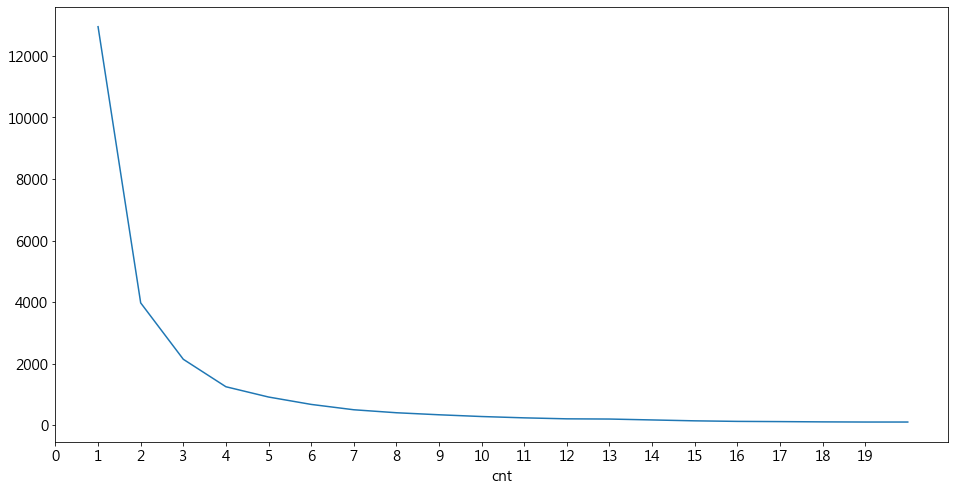

In [18]:
x =  ddf.groupby('cnt')['1'].sum()

x[:20].plot()
plt.xticks(ticks=range(0,20))
plt.show()

In [8]:
ddf.query('new_tags == "iu"')

,new_tags,cnt,len
2134,iu,30,2


## 2_1. 단어 제거
- 매번 빈번하게 등장하는 단어의 경우 학습과정 중 지나치게 많은 영향을 끼쳐 추론시 강한 편향을 가져올 수 있다
- 그렇기 때문에 빈도수가 높고 편향을 가져올 수 있는 단어를 제거 함.
 - 하지만 사용자사전에 나온 단어들은 제거하지 않는다

- 이후에도 이와 같은 방식으로 자연어 처리를 진행한다
 - 그렇기 때문에 이 방법에서 제거되는 단어들은 불용어로 따로 지정해 후에 전처리에 이용한다

In [9]:
app = ['음악','모음','노래','곡','날','오다','추천','듣','위','은','대','도','b','r','다','성','송','귀','뮤직','music','차트',
       'vol','길이']
# 방금, sh ,volume, 

rem6 = ddf.query('cnt <= 5 | (cnt <= 30 & len == 1)')['new_tags'].tolist()
rem6 = [w for w in rem6 if not w in add_dict]
rem6 += app

In [11]:
remove_10_28 = rem6 + stopword
with open( "data/10_28_stopword.pickle", "wb" ) as file:
    pickle.dump(remove_10_28, file)

len(remove_10_28)

19269

In [12]:
new_tag = pd.DataFrame()
new_tag['new_tags'] = [[x for x in txt if x not in rem6] for txt in konlpy_text['new_tags']]
new_tag.reset_index(inplace=True)
new_tag.head()

,index,new_tags
0,0,"[여행, 락]"
1,1,"[회상, 추억]"
2,2,"[편하, 까페, 잔잔]"
3,3,"[캐럴, 분위기, 연말, 겨울, 왕국, 크리스마스, 취하, 눈, 따듯]"
4,4,"[추억, 댄스]"


## 2_2. new_tags 저장

해당 방법으로 나온 new_tags를 통해 모델을 생성하기 때문에 json 형태로 저장

In [ ]:
xx = train.reset_index()
new_train = pd.merge(xx, new_tag, on='index')
new_train.drop('index',axis=1,inplace=True)
new_train = new_train[['tags','id','new_tags','plylst_title','songs','like_cnt','updt_date']]
new_train.to_json('data/1108_new_train.json', orient = 'records')